In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
from tsai.all import *

In [2]:
train_data = np.load('full_train_data_ordered.npy')
valid_data = np.load('full_valid_data_ordered.npy')
full_train_data = np.concatenate([train_data, valid_data], axis=0)

In [3]:
test_data = np.load('full_test_data_ordered.npy')
x_test = pd.read_csv('X_test.csv', index_col=[0], header=[0,1,2])

Classification

Load y data and create datasets and dataloaders

In [4]:
y_train = pd.read_csv('Y_train.csv', index_col=0)
y_valid = pd.read_csv('Y_valid.csv', index_col=0)
y = np.asarray(pd.concat([y_train, y_valid])).flatten()

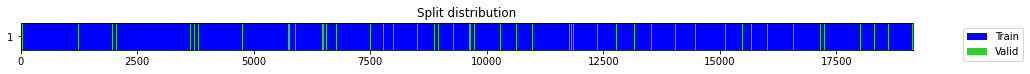

In [5]:
y_splits = get_splits(y, valid_size=.05, random_state=24, shuffle=True)

In [6]:
tfms  = [None, [Categorize()]]
dsets = TSDatasets(full_train_data, y, tfms=tfms, splits=y_splits, inplace=True)

In [7]:
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[16], batch_tfms=[TSStandardize()])

Create InceptionTime instance with classifier head

In [8]:
learn = TSClassifier(full_train_data, 
                     y, 
                     splits=y_splits, 
                     batch_tfms=[TSStandardize()],
                     arch=InceptionTimePlus, 
                     arch_config={'fc_dropout': 0.3, 'depth': 4, 'nf': 4}, 
                     metrics=RocAucBinary(), 
                     bs=16)

Find a good LR and fit

SuggestedLRs(valley=0.015848932787775993)

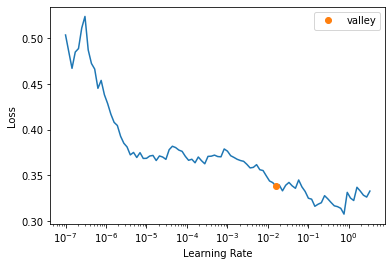

In [9]:
learn.lr_find()

In [10]:
learn.fit_one_cycle(6, 8e-3, wd=1e-2)

epoch,train_loss,valid_loss,roc_auc_score,time
0,0.209224,0.193619,0.887338,00:23
1,0.172955,0.202900,0.868211,00:20
2,0.168438,0.183603,0.883258,00:22
3,0.178085,0.179506,0.890986,00:21
4,0.147729,0.174731,0.889427,00:21
5,0.177707,0.173068,0.894568,00:20


Output test predictions

In [11]:
test_ds = dls.dataset.add_test(test_data)
test_dl = dls.valid.new(test_ds)
test_probas, *_ = learn.get_preds(dl=test_dl, save_preds=None)
test_probas = test_probas[:,1]

results = pd.DataFrame()
results['Id'] = x_test.index
results['Predicted'] = test_probas

results.to_csv(f'X_test_mort_filled.csv', index=False)

Regression

In [12]:
y_train = pd.read_csv('Y_train_reg.csv', index_col=0)
y_valid = pd.read_csv('Y_valid_reg.csv', index_col=0)
y = np.asarray(pd.concat([y_train, y_valid])).flatten()

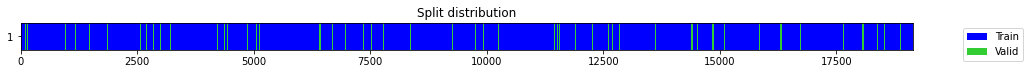

In [13]:
y_splits = get_splits(y, valid_size=.05, random_state=24, shuffle=True)

In [14]:
dsets = TSDatasets(full_train_data, y, tfms=None, splits=y_splits, inplace=True)

In [15]:
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[16], batch_tfms=[TSStandardize()])

Create InceptionTime instance with regression head

In [16]:
learn = TSRegressor(full_train_data, 
                     y, 
                     splits=y_splits, 
                     batch_tfms=[TSStandardize()],
                     arch=InceptionTimePlus, 
                     arch_config={'fc_dropout': 0.3, 'depth': 4, 'nf': 4}, 
                     metrics=rmse, 
                     bs=16)

Find a good LR and fit

SuggestedLRs(valley=0.12022644281387329)

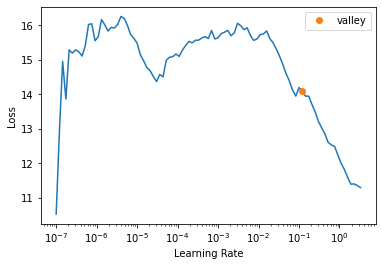

In [17]:
learn.lr_find()

In [18]:
learn.fit_one_cycle(6, 8e-2, wd=1e-2)

epoch,train_loss,valid_loss,_rmse,time
0,3.554819,3.255676,1.804349,00:20
1,3.304651,3.600461,1.897488,00:20
2,3.355842,3.266059,1.807224,00:19
3,3.247761,3.300639,1.816766,00:21
4,3.198590,3.227760,1.796597,00:21
5,3.008801,3.186460,1.785066,00:19


Output test predictions

In [19]:
test_ds = dls.dataset.add_test(test_data)
test_dl = dls.valid.new(test_ds)
test_probas, *_ = learn.get_preds(dl=test_dl, save_preds=None)

results = pd.DataFrame()
results['Id'] = x_test.index
results['Predicted'] = test_probas

results.to_csv(f'X_test_los_filled.csv', index=False)